# Sentiment Analysis of Movie Reviews

Sentiment analysis (also known as opinion mining or emotion AI) is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. Sentiment analysis is widely applied to voice of the customer materials such as reviews and survey responses, online and social media, and healthcare materials for applications that range from marketing to customer service to clinical medicine.

We have data with IMDB movie reviews: the texts of the reviews and the sentiment (whether the review is poritive or negative). The goal is to predict the marks for reviews in test dataset.

The metric to calculate the accuracy of predictions is AUC. One characteristic of the AUC is that it is independent of the fraction of the test population which is class 0 or class 1: this makes the AUC useful for evaluating the performance of classifiers on unbalanced data sets.

### 1.1 Load the data

In [1]:
import numpy as np
import pandas as pd
import re                               
import string
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

from wordcloud import WordCloud

import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv("C:/Users/balaj/Downloads/IMDB Dataset/IMDB Dataset.csv") 

In [3]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
df.shape

(50000, 2)

In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### 1.2 Word Cloud

Here, we are using wordcloud on the reviews tagged as positive and separately on reviews tagged as negative to see if there are any words that are clearly showing up as positive and negative. 

But as we can see below, there isn't anything particular showing up owing to the huge volume of reviews and their length, which is making the generic film review words show up on both the wordclouds.

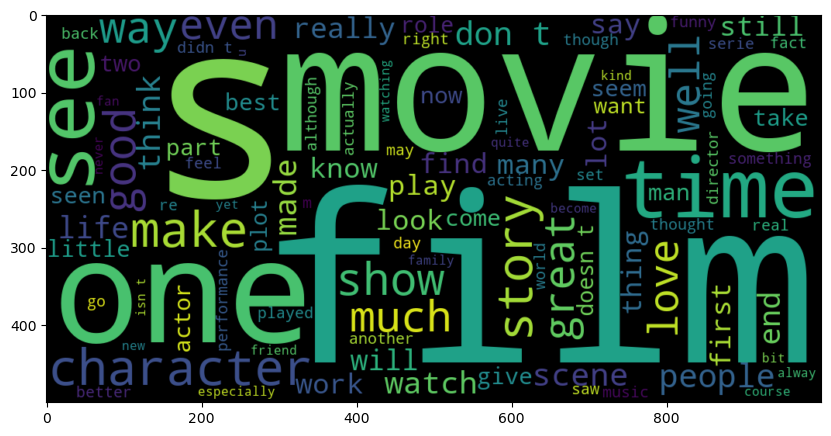

In [8]:
# Simple preprocessing to remove html tags before running worcloud

positive_list = [i for i in df[df['sentiment'] == 'positive']['review']]

positive_text = []

for review in positive_list:
    soup = BeautifulSoup(review, "html.parser").get_text()   # Removing the html strips   
    words = re.sub('[^a-zA-Z]', ' ', soup)  # Replacing non characters with space
    positive_text.append(words)
    
final_words = [word.split() for word in positive_text]
final_words = [j for i in final_words for j in i]
final = ' '.join(final_words)    

# Word cloud for positive review words 
    
plt.figure(figsize=(10,10))

WC = WordCloud(width=1000, height=500, max_words=100, min_font_size=5)
positive_words = WC.generate(final)
plt.imshow(positive_words, interpolation='bilinear')

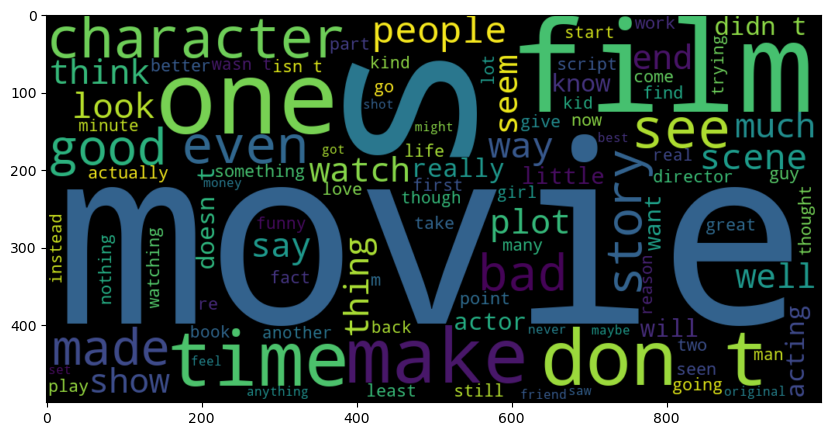

In [9]:
# Simple preprocessing to remove html tags before running worcloud 

negative_list = [i for i in df[df['sentiment'] == 'negative']['review']]

negative_text = []

for review in negative_list:
    soup = BeautifulSoup(review, "html.parser").get_text()   # Removing the html strips   
    words = re.sub('[^a-zA-Z]', ' ', soup)  # Replacing non characters with space
    negative_text.append(words)
    
final_words = [word.split() for word in negative_text]
final_words = [j for i in final_words for j in i]
final = ' '.join(final_words)    

# Word cloud for negative review words 
    
plt.figure(figsize=(10,10))

WC = WordCloud(width=1000, height=500, max_words=100, min_font_size=5)
negative_words = WC.generate(final)
plt.imshow(negative_words, interpolation='bilinear')

### 1.3 Preprocess raw text for Sentiment analysis

Data preprocessing is one of the critical steps in any machine learning project. It includes cleaning and formatting the data before feeding into a machine learning algorithm. For NLP, the preprocessing steps are comprised of the following tasks:


* Lowercasing
* Removing stop words and punctuation
* Stemming
* Vectorization

In [10]:
# Labeling the sentiment text

lb = LabelBinarizer()
sentiment_data = lb.fit_transform(df['sentiment'])
sentiment_data.shape

(50000, 1)

In [11]:
np.unique(sentiment_data)

array([0, 1])

In [12]:
# Splitting the dataset - both reviews and their corresponding sentiments

# Training set
train_reviews = df.review[:40000]
train_sentiments = sentiment_data[:40000]

# Testing set
test_reviews = df.review[40000:]
test_sentiments = sentiment_data[40000:]

print(train_reviews.shape, train_sentiments.shape)
print(test_reviews.shape, test_sentiments.shape)

(40000,) (40000, 1)
(10000,) (10000, 1)


In [13]:
# Creating a list of stopwords and punctuations

stopwords_english = stopwords.words('english') 
punctuations = string.punctuation
stopwords_final = stopwords_english + list(punctuations)

# Instantiating a Stemmer

stemmer = SnowballStemmer('english') 

# Creating a function to Preprocess each review 

def preprocess(reviews):
    processed_review = []   
    for review in reviews:
        soup = BeautifulSoup(review, "html.parser").get_text()   # Removing the html strips   
        words = re.sub('[^a-zA-Z]', ' ', soup)  # Replacing non characters with space
        lowercase = words.lower().split()  # Converting all the words in the review into lowercase
        filtered = [word for word in lowercase if word not in stopwords_final]  # Removing stop words and punctuations in the review
        stemmed = [stemmer.stem(word) for word in filtered]   # Stemming each word in the review
        final = ' '.join(stemmed)
        processed_review.append(final)  # Appending the review into the processed list
    return processed_review

In [14]:
train_reviews_processed = preprocess(train_reviews)
test_reviews_processed = preprocess(test_reviews)

In [15]:
# Comparing a single review pre and post processing

print(train_reviews[0])
print('')
print(train_reviews_processed[0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

### 1.3 Creating Bag of words, TF-IDF

#### <u>Bag of Words Model</u>

The Bag of Words (BoW) model is the simplest form of text representation in numbers. As mentioned in the name, we can represent a sentence as a bag of words vector (a string of numbers).

Let’s assume there are three types of movie reviews:

Review 1: This movie is very scary and long
Review 2: This movie is not scary and is slow
Review 3: This movie is spooky and good

We will first build a vocabulary from all the unique words in the above three reviews. The vocabulary consists of these 11 words: ‘This’, ‘movie’, ‘is’, ‘very’, ‘scary’, ‘and’, ‘long’, ‘not’,  ‘slow’, ‘spooky’,  ‘good’.

We can now take each of these words and mark their occurrence in the three movie reviews above with 1s and 0s. This will give us 3 vectors for 3 reviews:

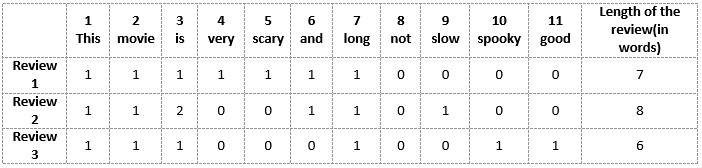

Vector of Review 1: [1 1 1 1 1 1 1 0 0 0 0]

Vector of Review 2: [1 1 2 0 0 1 1 0 1 0 0]

Vector of Review 3: [1 1 1 0 0 0 1 0 0 1 1]

And that’s the core idea behind a Bag of Words (BoW) model.

#### Drawbacks

In the above example, we can have vectors of length 11. However, we start facing issues when we come across new sentences:

1) If the new sentences contain new words, then our vocabulary size would increase and thereby, the length of the vectors would increase too.
2) Additionally, the vectors would also contain many 0s, thereby resulting in a sparse matrix (which is what we would like to avoid)
3) We are retaining no information on the grammar of the sentences nor on the ordering of the words in the text.


Source - https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/#:~:text=Bag%20of%20Words%20just%20creates,vectors%20are%20easy%20to%20interpret.

In [16]:
# Count vectorizer for bag of words

cv = CountVectorizer(min_df = 3, binary = False)

# Transformed train and test reviews

cv_train_reviews = cv.fit_transform(train_reviews_processed)
cv_test_reviews = cv.transform(test_reviews_processed)

print('BOW_cv_train:', cv_train_reviews.shape)
print('BOW_cv_test:', cv_test_reviews.shape)

BOW_cv_train: (40000, 28184)
BOW_cv_test: (10000, 28184)


In [17]:
feature_names = cv.get_feature_names()
print('')
print("Number of features: {}".format(len(feature_names)))
print('')
print("First 20 features:\n{}".format(feature_names[:20]))
print('')
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print('')
print("Every 2000th feature:\n{}".format(feature_names[::2000]))


Number of features: 28184

First 20 features:
['aa', 'aaa', 'aaargh', 'aag', 'aah', 'aaliyah', 'aam', 'aamir', 'aankhen', 'aapk', 'aardman', 'aargh', 'aaron', 'aatish', 'ab', 'aback', 'abandon', 'abba', 'abbey', 'abbi']

Features 20010 to 20030:
['ranc', 'ranch', 'rancher', 'rancho', 'rancid', 'rand', 'randal', 'randel', 'randi', 'randl', 'randolph', 'random', 'rang', 'ranger', 'rangoon', 'rani', 'rank', 'rankin', 'rankl', 'ranma']

Every 2000th feature:
['aa', 'beckinsal', 'ceremoni', 'daylight', 'escape', 'glob', 'immobil', 'lawmen', 'minghella', 'padr', 'rampag', 'sept', 'subsum', 'underfoot', 'yugoslav']


#### <u>TF-IDF Model</u>

Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

#### Term Frequency (TF)

Let’s first understand Term Frequency (TF). It is a measure of how frequently a term, t, appears in a document, d:

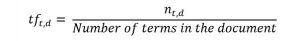

Here, in the numerator, n is the number of times the term “t” appears in the document “d”. Thus, each document and term would have its own TF value.

We will again use the same vocabulary we had built in the Bag-of-Words model to show how to calculate the TF for, 
Review 2: This movie is not scary and is slow

Here,

Vocabulary: ‘This’, ‘movie’, ‘is’, ‘very’, ‘scary’, ‘and’, ‘long’, ‘not’,  ‘slow’, ‘spooky’,  ‘good’
Number of words in Review 2 = 8
TF for the word ‘this’ = (number of times ‘this’ appears in review 2)/(number of terms in review 2) = 1/8
Similarly,

TF(‘movie’) = 1/8
TF(‘is’) = 2/8 = 1/4
TF(‘very’) = 0/8 = 0
TF(‘scary’) = 1/8
TF(‘and’) = 1/8
TF(‘long’) = 0/8 = 0
TF(‘not’) = 1/8
TF(‘slow’) = 1/8
TF( ‘spooky’) = 0/8 = 0
TF(‘good’) = 0/8 = 0

We can calculate the term frequencies for all the terms and all the reviews in this manner:

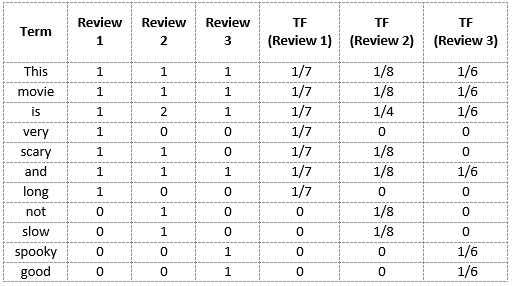

#### Inverse Document Frequency (IDF)

IDF is a measure of how important a term is. We need the IDF value because computing just the TF alone is not sufficient to understand the importance of words:

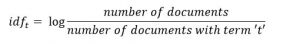

We can calculate the IDF values for the all the words in Review 2:

IDF(‘this’) =  log(number of documents/number of documents containing the word ‘this’) = log(3/3) = log(1) = 0

Similarly,

IDF(‘movie’, ) = log(3/3) = 0\
IDF(‘is’) = log(3/3) = 0\
IDF(‘not’) = log(3/1) = log(3) = 0.48\
IDF(‘scary’) = log(3/2) = 0.18\
IDF(‘and’) = log(3/3) = 0\
IDF(‘slow’) = log(3/1) = 0.48

We can calculate the IDF values for each word like this. Thus, the IDF values for the entire vocabulary would be:

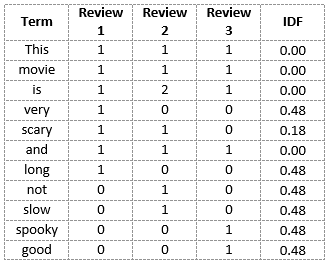

Hence, we see that words like “is”, “this”, “and”, etc., are reduced to 0 and have little importance; while words like “scary”, “long”, “good”, etc. are words with more importance and thus have a higher value.

We can now compute the TF-IDF score for each word in the corpus. Words with a higher score are more important, and those with a lower score are less important:

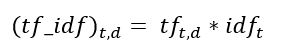

We can now calculate the TF-IDF score for every word in Review 2:

TF-IDF(‘this’, Review 2) = TF(‘this’, Review 2) * IDF(‘this’) = 1/8 * 0 = 0

Similarly,

TF-IDF(‘movie’, Review 2) = 1/8 * 0 = 0\
TF-IDF(‘is’, Review 2) = 1/4 * 0 = 0\
TF-IDF(‘not’, Review 2) = 1/8 * 0.48 = 0.06\
TF-IDF(‘scary’, Review 2) = 1/8 * 0.18 = 0.023\
TF-IDF(‘and’, Review 2) = 1/8 * 0 = 0\
TF-IDF(‘slow’, Review 2) = 1/8 * 0.48 = 0.06

Finally, we can calculate the TF-IDF scores for all the words with respect to all the reviews:

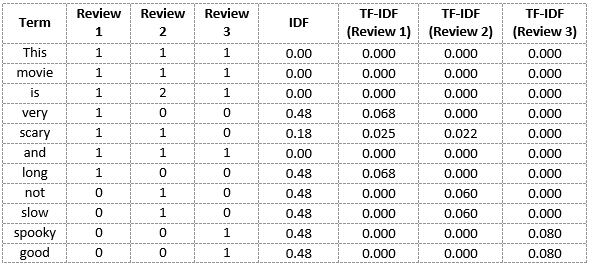

We have now obtained the TF-IDF scores for our vocabulary. TF-IDF also gives larger values for less frequent words and is high when both IDF and TF values are high i.e the word is rare in all the documents combined but frequent in a single document.

Source - https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/#:~:text=Bag%20of%20Words%20just%20creates,vectors%20are%20easy%20to%20interpret.

In [18]:
# Tf-idf vectorizer

tv = TfidfVectorizer(min_df = 3, use_idf = True)

# Transformed train and test reviews

tv_train_reviews = tv.fit_transform(train_reviews_processed)
tv_test_reviews = tv.transform(test_reviews_processed)

print('Tfidf_train:', tv_train_reviews.shape)
print('Tfidf_test:', tv_test_reviews.shape)

Tfidf_train: (40000, 28184)
Tfidf_test: (10000, 28184)


In [19]:
feature_names = tv.get_feature_names()
print('')
print("Number of features: {}".format(len(feature_names)))
print('')
print("First 20 features:\n{}".format(feature_names[:20]))
print('')
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print('')
print("Every 2000th feature:\n{}".format(feature_names[::2000]))


Number of features: 28184

First 20 features:
['aa', 'aaa', 'aaargh', 'aag', 'aah', 'aaliyah', 'aam', 'aamir', 'aankhen', 'aapk', 'aardman', 'aargh', 'aaron', 'aatish', 'ab', 'aback', 'abandon', 'abba', 'abbey', 'abbi']

Features 20010 to 20030:
['ranc', 'ranch', 'rancher', 'rancho', 'rancid', 'rand', 'randal', 'randel', 'randi', 'randl', 'randolph', 'random', 'rang', 'ranger', 'rangoon', 'rani', 'rank', 'rankin', 'rankl', 'ranma']

Every 2000th feature:
['aa', 'beckinsal', 'ceremoni', 'daylight', 'escape', 'glob', 'immobil', 'lawmen', 'minghella', 'padr', 'rampag', 'sept', 'subsum', 'underfoot', 'yugoslav']


### 1.4 Logistic Regression

In [20]:
# Training the model

lr = LogisticRegression(penalty = 'l2', max_iter = 500, C = 1, random_state = 42)

In [21]:
# Fitting the LR model for Bag of words

lr_bow = lr.fit(cv_train_reviews, train_sentiments)

# Predicting the model

lr_bow_predict = lr.predict(cv_test_reviews)

# Accuracy score

lr_bow_score = accuracy_score(test_sentiments, lr_bow_predict)
print("ROC AUC Score for Logistic Regression based on Bag of Words:", lr_bow_score)

ROC AUC Score for Logistic Regression based on Bag of Words: 0.8823


In [22]:
# Fitting the LR model for tfidf 

lr_tfidf = lr.fit(tv_train_reviews, train_sentiments)

# Predicting the model 

lr_tfidf_predict = lr.predict(tv_test_reviews)

# Accuracy score

lr_tfidf_score = accuracy_score(test_sentiments, lr_tfidf_predict)
print("ROC AUC Score for Logistic Regression based on TF-IDF:", lr_tfidf_score)

ROC AUC Score for Logistic Regression based on TF-IDF: 0.8907


We see a good accuracy score for both Bag of Words and TF-IDF with the TF-IDF model having a slighly higher accuracy. Now let's check the results for Multinomial Naive Bayes.

In [23]:
# Checking the sentiment using LR model for a new example

text = ['This movie rocks', 'This movie sucks', 'This movie is not so bad']

final_text = preprocess(text)

new = cv.transform(final_text)

lr.predict(new)

array([1, 0, 0])

We can clearly see that when the review has 'rocks', the sentiment is positive (1) while when the review has 'sucks', the sentiment is negative (0). But we can also see that the model isnt great in identifying context and hence marks the third review as negative (0), even though it's a positive review.

### 1.5 Multinomial Naive Bayes'

In [24]:
mnb = MultinomialNB(alpha=0.01)

In [25]:
# Fitting the MNB model for Bag of words

mnb_bow = mnb.fit(cv_train_reviews, train_sentiments)

# Predicting the model

mnb_bow_predict = mnb.predict(cv_test_reviews)

# Accuracy score

mnb_bow_score = accuracy_score(test_sentiments, mnb_bow_predict)
print("ROC AUC Score for Multinomial Naive Bayes based on Bag of Words:", mnb_bow_score)

ROC AUC Score for Multinomial Naive Bayes based on Bag of Words: 0.852


In [26]:
# Fitting the MNB model for tfidf 

mnb_tfidf = mnb.fit(tv_train_reviews, train_sentiments)

# Predicting the model 

mnb_tfidf_predict = mnb.predict(tv_test_reviews)

# Accuracy score

mnb_tfidf_score = accuracy_score(test_sentiments, mnb_tfidf_predict)
print("ROC AUC Score for Multinomial Naive Bayes based on TF-IDF:", mnb_tfidf_score)

ROC AUC Score for Multinomial Naive Bayes based on TF-IDF: 0.8517


We see a slightly lower accuracy score compared to the Logistic Regression model scores. But the scores for both Bag of Words and TF-IDF models are similar here as well. 

In [27]:
# Checking the sentiment using MNB model for a new example

text = ['This movie rocks', 'This movie sucks', 'This movie is not so bad']

final_text = preprocess(text)

new = cv.transform(final_text)

mnb.predict(new)

array([1, 0, 0])

We can clearly see that when the review has 'rocks', the sentiment is positive (1) while when the review has 'sucks', the sentiment is negative (0). But we can also see that the model isnt great in identifying context and hence marks the third review as negative (0), even though it's a positive review. That's where Transformers can play a key role in identifying the correct sentiment.